In [40]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline 
import tensorflow as tf 
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model , load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image 


# Chargement des modèles depuis l'ensemble de données


In [41]:
loaded_model_gender = load_model('/kaggle/input/testing-models-old/modele_gender.h5')
loaded_model_age = load_model('/kaggle/input/testing-models-old/modele_age.h5')


# Creation d'un dataframe des données de Test

In [42]:
repertoire_age_list=[]
reference_age_list=[]
face_id_age_list=[]
repertoire_gender_list=[]
reference_gender_list=[]
face_id_gender_list=[]
ages = []
genders=[]


chemin_fichier_age = '/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/age_test.txt'
with open(chemin_fichier_age, 'r') as fichier_age_test:
     for ligne in fichier_age_test:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  # Assurez-vous qu'il y a deux éléments sur la ligne
                image, age = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_age_list.append(repertoire)
                reference_age_list.append(reference)
                face_id_age_list.append(int(face_id))
                ages.append(int(age))  # Convertissez l'âge en entier si nécessaire

chemin_fichier_gender ='/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/gender_test.txt'
with open(chemin_fichier_gender, 'r') as fichier_gender_test:
# Lecture ligne par ligne
     for ligne in fichier_gender_test:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  # Assurez-vous qu'il y a deux éléments sur la ligne
                image, gender = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_gender_list.append(repertoire)
                reference_gender_list.append(reference)
                face_id_gender_list.append(int(face_id))
                genders.append(int(gender))  
                        

data_age_test= {'Répertoire': repertoire_age_list, 'Reference_image':reference_age_list,'Face_id':face_id_age_list,'Age': ages}
df_age_test = pd.DataFrame(data_age_test)
data_gender_test = {'Répertoire': repertoire_gender_list, 'Reference_image':reference_gender_list,'Face_id':face_id_gender_list, 'Gender': genders}
df_gender_test = pd.DataFrame(data_gender_test)
# Retirer 50% des lignes avec l'âge 4 de manière aléatoire
rows_to_remove = df_age_test[df_age_test['Age'] == 4].sample(frac=0.5)  
df_age_test = df_age_test.drop(rows_to_remove.index)


In [43]:
df_age_test.shape

(2526, 4)

In [44]:
df_gender_test.shape

(3318, 4)

# Analyse des données de Test

### Distribution des âges données Test

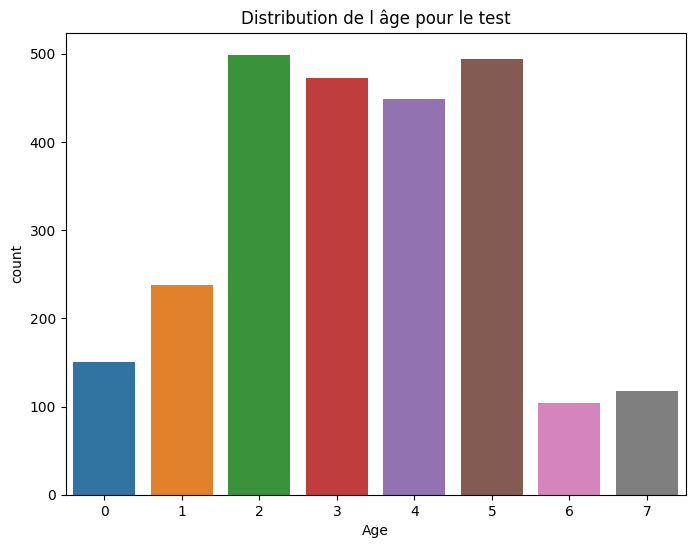

In [45]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Age', data=df_age_test)
plt.title('Distribution de l âge pour le test')
plt.show()

### Distribution des genres données Test

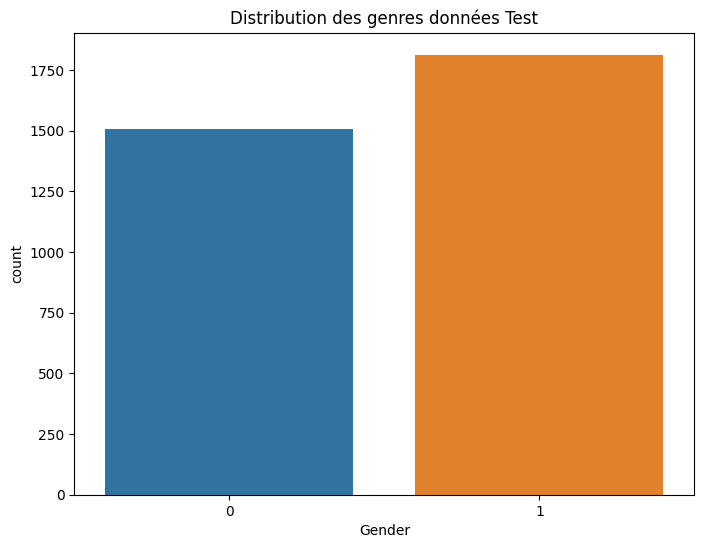

In [46]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df_gender_test)
plt.title('Distribution des genres données Test')
plt.show()

### Extraction des caractéristiques pour le genre

In [47]:
def extract_features(images):
    features= []
    for image in tqdm(images): 
        img= load_img('/kaggle/input/image-aligned/aligned/'+image)
        img= img.resize((128,128), Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
        
    features = np.array(features)
    features=features.reshape(len(features),128,128,3)
    return features

In [48]:
X_gender_test = extract_features(df_gender_test['Répertoire']+'/'+df_gender_test['Reference_image'])
y_gender_test= np.array(df_gender_test['Gender'])

  0%|          | 0/3318 [00:00<?, ?it/s]

# Normalisation des données de Test

In [49]:
X_gender_test= X_gender_test/255.0

In [50]:
X_test.shape

(3318, 128, 128, 3)

### calcul de la precision genre

In [51]:

predictions = loaded_model_gender.predict(X_gender_test)
predicted_classes_gender = np.round(predictions)

accuracy = accuracy_score(y_gender_test, predicted_classes_gender)
print(f'Accuracy sur les données de test : {accuracy}')

104/104 [==============================] - 12s 115ms/step
Accuracy sur les données de test : 0.9138034960819771


### prediction d'un echantillon pour le genre

In [52]:
sample_index = 1
print(f"Prédictions probables : {predictions[sample_index]}")
print(f"Classe prédite : {predicted_classes_gender[sample_index]}")
actual_class = y_gender_test[sample_index]
print(f"Classe réelle : {actual_class}")

Prédictions probables : [0.38552245]
Classe prédite : [0.]
Classe réelle : 0


### extraction des caracteriqtiques pour l'âge

In [53]:
X_age_test = extract_features(df_age_test['Répertoire']+'/'+df_age_test['Reference_image'])
y_age_test=np.array(df_age_test['Age'])
X_age_test= X_age_test/255.0

  0%|          | 0/2526 [00:00<?, ?it/s]

### Conversion des étiquettes de l'âge 

In [54]:
label_encoder = LabelEncoder()
y_test_age_encoded = label_encoder.fit_transform(y_age_test)
y_test_age_categorical = to_categorical(y_test_age_encoded, num_classes=8)


### Calcul de la precision âge 

In [55]:

predictions = loaded_model_age.predict(X_age_test)

predicted_classes = np.argmax(predictions, axis=1)

y_test_age = np.argmax(y_test_age_categorical, axis=1)

accuracy = accuracy_score(y_test_age, predicted_classes)
print(f'Accuracy sur les données de test : {accuracy}')


79/79 [==============================] - 11s 133ms/step
Accuracy sur les données de test : 0.8218527315914489


### prediction pour un échantillon

In [56]:
sample_index = 12  
print(f"Prédictions probables : {predictions[sample_index]}")
print(f"Classe prédite : {predicted_classes[sample_index]}")
actual_class = y_test_age[sample_index]
print(f"Classe réelle : {actual_class}")

Prédictions probables : [2.92378559e-06 6.70813024e-05 6.34839339e-03 1.89066753e-01
 8.56013298e-02 5.63531756e-01 3.23488414e-02 1.23032816e-01]
Classe prédite : 5
Classe réelle : 5
